In [1]:
import xfields as xf
import xobjects as xo
import xpart as xp
import xtrack as xt
import json
import matplotlib.pyplot as plt
import numpy as np
import xtrack as xt

In [1]:
'''
Author: Adnan Ghribi
Date: 2023-10-03
Description: This file contains utility functions for the v11 classes.
'''

# Import the necessary packages
import json, sys, os, warnings, random, string, shutil
import numpy as np
from astropy.io import ascii
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from tqdm import tqdm
import scipy.constants as cons
import xtrack as xt
import xpart as xp
import xfields as xf
import xobjects as xo
import xcoll as xc
import xwakes as xw
#

def dump_data(filename, output):
    with open(filename, 'w') as json_file:
        json.dump(output, json_file)

def make_unique(filename):
    make_unique = lambda filename: f"{filename.rsplit('.', 1)[0]}_{''.join(random.choices(string.ascii_lowercase + string.digits, k=8))}.{filename.rsplit('.', 1)[1]}"
    new_name = make_unique(filename)
    return new_name


class beam_param:
    """
    Class to define the beam parameters from input file
    """
    def __init__(self, mode, **kw):
        if mode == None:
            print('No mode entered -> default = z')
            mode = 'z'
        self.filename()
        self.read_param(mode)
        self.set_param()

    def filename(self):
        # parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
        input_dir = '_inputs/'#parent_dir + '/input_data/'
        self.filename = input_dir + 'Booster_parameter_table.json'
        
    def read_param(self, mode):
        inputs_tab = json.load(open(self.filename))
        print(inputs_tab.keys())

        # define variables
        self.C = inputs_tab['C']['value'] # circumference [m]
        self.Np = inputs_tab['Np'][mode] # number of particles per bunch
        self.Nb = inputs_tab['Nb'][mode] # number of bunches
        self.Etot = inputs_tab['E']['injection'] # energy at injection [eV]
        self.epsnx = inputs_tab['bunch']['epsnx']['value'] # normalised horizontal emittance [m]
        self.epsny = inputs_tab['bunch']['epsny']['value'] # normalised horizontal emittance [m]
        self.sigmaz = inputs_tab['bunch']['sigmaz']['value'] # bunch length at injection [m]
        self.sigmae = inputs_tab['bunch']['sigmae']['value'] # energy spread at injection
        self.Qx = inputs_tab['optics']['Qx'][mode] # horizontal tune
        self.Qy = inputs_tab['optics']['Qy'][mode] # vertical tune
        self.chix = inputs_tab['optics']['chix'][mode] # horizontal chromaticity
        self.chiy = inputs_tab['optics']['chiy'][mode] # horizontal chromaticity
        self.alpha = inputs_tab['optics']['alpha'][mode] # momentum compaction
        self.I2 = inputs_tab['optics']['I2'][mode] # 2nd synchrotron integral
        self.I3 = inputs_tab['optics']['I3'][mode] # 3rd synchrotron integral
        self.I5 = inputs_tab['optics']['I5'][mode] # 5th synchrotron integral
        self.I6 = 0 # 6th synchrotron integral
        self.dpt = inputs_tab['optics']['dpt'][mode] # maximum energy acceptance at injection
        self.damp_xy = inputs_tab['optics']['damp_xy'][mode] # transverse damping time at injection energy
        self.damp_s = inputs_tab['optics']['damp_s'][mode] # longitudinal damping time at injection energy
        self.coupling = inputs_tab['optics']['coupling'][mode] # horizontal vertical coupling
        self.Cq = 3.8319e-13
        self.Cgamma = 8.846e-05
        self.Erest = 510998.9499961642 # rest energy [eV]
        self.Egain = 0 # energy gain [eV]
        self.freq = inputs_tab['RF']['RF_freq'][mode] # RF frequency [Hz]
        self.Vtot = inputs_tab['RF']['Vtot'][mode] # total cavities voltage [eV]
        self.Qs = inputs_tab['RF']['Qs_inj'][mode] # synchronous tune at injection
        self.phi_s = inputs_tab['RF']['phis_inj'][mode] # synchronous phase at injection
        
    def set_param(self):
        self.lambdaRF = cons.c/self.freq # RF wavelength
        self.frev = cons.c/self.C # revolution frequency
        self.h = self.freq/self.frev # Schottky number
        self.U0 = self.Cgamma*(self.Etot*1e-9)**4/2/np.pi*self.I2*1e9 # Synchrotron energy loss per turn
        self.gamma = self.Etot / self.Erest
        self.sig_e_eq = np.sqrt(self.Cq*self.gamma**2*self.I3/(2*self.I2))#*(self.Etot*1e-9)**2)
        self.emit_eq = self.Cq * self.gamma**2 * self.I5 / self.I2 # geometrical equilibrium emittance
        self.epsnx_eq = self.emit_eq * self.gamma # normalized equilibrium emittance X
        self.epsny_eq = self.epsnx_eq * 2e-3 # normalized equilibrium emittance Y
        self.eta = 1/self.gamma**2-self.alpha # momentum compaction

class _collective_():
    '''
    Class for tracking with collective effects
    Usage:
    _inputs = {
    'bunch_intensity' : bunch_intensity,
    'n_turns' : n_turns, # number of turns
    'n_macroparticles' : n_macroparticles,
    'optics_file' : fodo_json, # optics file in json format
    'ibs' : ibs, # boolean
    'wake' : wake, # boolean
    'detuning' : detuning, # boolean
    'dispersion' : dispersion, # boolean
    'origin' : origin, # can be "map" or "lattice" for tracking through the whole lattice or the linear map
    'kernel': kernel, # kernel to be used, can be 'cpu' or 'gpu' or 'omp'
    'comp' : 'bench',
    'comment': 'no wake, no gaussian noise, no dispersion, no detuning'
}
    '''
    # initialize the class
    def __init__(self, _inputs=None, **kw):
        print ('== loading inputs ==')
        self._set_defaults()
        if _inputs is not None:
            for key, value in _inputs.items():
                setattr(self, key, value)
                print(key, value)
        else:
            print('Some input parameters are missing')
        print('\n== setting defaults ==')
        print('\n== setting parameters ==')
        self._set_params()
        self._set_path()
        print('\n== setting line ==\n')
        self._set_line_param()
        print('\n== calculating one turn map ==\n')
        self._set_map()
        print('\n== setting IBS ==\n')
        self._set_ibs()
        print('\n== creating bunch ==\n')
        self._set_bunch()
        # print('\n== setting wake ==\n')
        # self._set_wake()
        print('\n== setting monitor ==\n')
        self._set_monitor()
        
    def _set_defaults(self):
        # input files
        self.input_dir = '_inputs/'
        self.optics_file = self.input_dir + 'heb_ring_withcav.json' # optics file
        self.mass =xp.ELECTRON_MASS_EV # mass of the particle
        self.q0 = -1 # charge of the particle
        self.wakefile = self.input_dir + 'heb_wake_round_cu_30.0mm.csv' # wake file
        # slicing parameters
        self.n_slices_wake = 500
        self.slicing_mode = 'fixed_cuts' # can be 'fixed_cuts' or 'from_first_to_last_particles'
        self.fixed_cuts_perc_min_max = 0.50
        # chunk size for tracking
        self.chunk_size = 1000
        # IBS parameters
        self.n_slices_ibs = 50
        self.ibs_formalism = 'nagaitsev' # can be 'nagaitsev' or 'kinetic'
        # bunch parameters
        self.bunch = 'matched' # can be 'matched' or 'unmatched'
        
    def _set_params(self, **kw):
        param = beam_param(self.mode)
        for key, value in param.__dict__.items():
            setattr(self, key, value) 
        self.limit_z = 3 * self.sigmaz
        if self.kernel == 'gpu':
            self.context = xo.ContextCupy()
        elif self.kernel == 'omp':
            self.context = xo.ContextCpu(omp_num_threads="auto")
        else:
            self.context = xo.ContextCpu()
        self.n_chunk = int(np.ceil(self.n_turns/self.chunk_size))
        self.lag_rf = 180
    
    def _set_path(self):
        parent_dir = os.getcwd()#os.path.dirname(os.getcwd())
        self.input_dir = parent_dir + '/_inputs'
        if self.dir_name is not None:
            self.dir_ = self.dir_name + '/'
        else:
            self.dir_ = 'part' + str(int(self.Np/1e10)) + 'e10_freq' + str(int(self.freq*1e-6)) + '_sz'+str(self.sigmaz) + '_mode_'+self.mode+'/'
        if self.comp == 'feynman':
            self.res_directory = parent_dir + '/.results/results_feynman/' + self.dir_
        if self.comp == 'ccin2p3':
            self.res_directory = parent_dir + '/.results/results_ccin2p3/' + self.dir_
        elif self.comp == 'lxplus':
            self.res_directory = '/eos/project-f/fcc-ee-ce/Adnan/_dev_collective_effects/fccee_collective_effects/pyhdt_heb/heb_single_bunch/.results/results_lxplus/' + self.dir_
        elif self.comp == 'bench':
            self.res_directory = parent_dir + '/_outputs/'+ self.dir_
        self.fig_directory = self.res_directory + 'figures/'
        self.data_directory = self.res_directory +'data/'
        if os.path.exists(self.res_directory)==False:
            os.makedirs(self.res_directory)
        if os.path.exists(self.fig_directory)==False:
            os.makedirs(self.fig_directory)
        if os.path.exists(self.data_directory)==False:
            os.makedirs(self.data_directory)
        if os.path.exists(self.data_directory + 'moments')==False:
            os.makedirs(self.data_directory + 'moments')
        delete_folder = False
        if os.path.exists(self.fig_directory) and delete_folder:    
            shutil.rmtree(self.fig_directory)
            os.makedirs(self.fig_directory)
        folders_names = ['', 'phasespaces_xxp', 'phasespaces_yyp', 'phasespaces_zdp',
                     'profile_x', 'profile_y', 'profile_z'
                     ]
        for i in folders_names:
            try:
                os.makedirs(self.fig_directory+i)
            except:
                pass 
        
    def _set_line_param(self):
        self.line = xt.Line.from_json(self.optics_file) # import lattice
        self.particle_ref = xp.Particles(mass0=self.mass, q0=self.q0, gamma0=self.gamma) # define reference particle
        self.line.particle_ref  = self.particle_ref # assign reference particle to the line
        self.line.slice_thick_elements( slicing_strategies=[
        # Slicing with thin elements
            xt.Strategy(slicing=xt.Teapot(2)), # (1) Default applied to all elements
            xt.Strategy(slicing=xt.Teapot(3), element_type=xt.Bend), # (2) Selection by element type
            xt.Strategy(slicing=xt.Teapot(5), element_type=xt.Quadrupole),  # (4) Selection by element type
            xt.Strategy(slicing=xt.Teapot(3), element_type=xt.Sextupole),  # (4) Selection by element type
        ])
        print('building tracker')
        self.line.build_tracker() # build the tracker
        print('configuring radiation')
        self.line.configure_radiation(model='mean') # configure radiation
        self.env = self.line.env
        print('calculating twiss')
        self.tw = self.line.twiss(method="6d", eneloss_and_damping=True) # get twiss parameters
        self.C = self.tw.s[-1] # circumference
        self.qx = self.tw.qx # horizontal tune
        self.qy = self.tw.qy # vertical tune
        self.dqx = self.tw.dqx # horizontal chromaticity
        self.dqy = self.tw.dqy # vertical chromaticity
        self.eneloss_turn = self.tw.eneloss_turn
        df = self.tw.to_pandas() # convert to pandas dataframe
        betax_0 = self.C / (2*np.pi*self.tw.qx) # betax from the tune
        # betay_0 = self.param.C / (2*np.pi*self.params.Qy) # betax from the tune
        # the 10 closest values to the betax_0
        df['distance'] = abs(df.betx - betax_0)
        closest = df.nsmallest(10, 'distance')
        closest = closest.drop('distance', axis=1)
        self.index = closest.dx.idxmin()
        self.betax = closest.betx[self.index] # horizontal beta function from the twiss
        self.betay = closest.bety[self.index] # vertical beta function from the twiss
        self.alphax = closest.alfx[self.index] # horizontal alpha function from the twiss
        self.alphay = closest.alfy[self.index] # vertical alpha function from the twiss
        if self.dispersion==True:
            self.dx = closest.dx[self.index] # horizontal dispersion from the twiss
            self.dy = closest.dy[self.index] # vertical dispersion from the twiss
        else:
            self.dx = 0
            self.dy = 0
        # get amplitude detuning coefficients
        if self.detuning==True:
            print('Extracting detuning coefficients')
            det_= self.line.get_amplitude_detuning_coefficients(
                nemitt_x=self.epsnx, 
                nemitt_y=self.epsny, 
                num_turns=500, 
                a0_sigmas=0.01, 
                a1_sigmas=0.1, 
                a2_sigmas=0.2
            )
            self.det_xx = det_['det_xx']
            self.det_yy = det_['det_yy']
            self.det_xy = det_['det_xy']
            self.det_yx = det_['det_yx']
        else:
            self.det_xx = 0
            self.det_yy = 0
            self.det_xy = 0
            self.det_yx = 0
        # get synchrotron parameters
        self.damping_rate_emit_h = 2 * self.tw.damping_constants_turns[0] # horizontal damping rate
        self.damping_rate_emit_v = 2 * self.tw.damping_constants_turns[1] # horizontal damping rate
        self.damping_rate_emit_zeta = 2 * self.tw.damping_constants_turns[2] # longitudinal damping rate
        # Compute gaussian noise amplitudes to model quantum excitation
        if self.gaussian_noise==True:
            self.gauss_noise_ampl_px = 2 * np.sqrt(self.tw.eq_gemitt_x * self.damping_rate_emit_h / self.tw.betx[self.index])
            self.gauss_noise_ampl_x = 0
            self.gauss_noise_ampl_py = 2 * np.sqrt(self.tw.eq_gemitt_y * self.damping_rate_emit_h / self.tw.bety[self.index])
            self.gauss_noise_ampl_y = 0.
            self.gauss_noise_ampl_delta = 2 * np.sqrt(self.tw.eq_gemitt_zeta * self.damping_rate_emit_zeta / self.tw.bets0)
    
    def _set_map(self):
        self.map =  xt.LineSegmentMap(
                    length=self.C,
                    qx=self.qx,
                    qy=self.qy,
                    dqx=self.dqx,
                    dqy=self.dqy,
                    momentum_compaction_factor=self.alpha,
                    betx=self.betax,
                    bety=self.betay,
                    alfx=self.alphax,
                    alfy=self.alphay,
                    dx = self.dx,
                    dy = self.dy,
                    det_xx=self.det_xx,
                    det_xy=self.det_xy,
                    det_yx=self.det_yx,
                    det_yy=self.det_yy,  
                    damping_rate_x=  self.damping_rate_emit_h,
                    damping_rate_y=  self.damping_rate_emit_v,
                    # In longitudinal all damping goes on the momentum
                    damping_rate_zeta=0,
                    damping_rate_pzeta=2 * self.tw.damping_constants_turns[2],
                    gauss_noise_ampl_px=self.gauss_noise_ampl_px,
                    gauss_noise_ampl_py=self.gauss_noise_ampl_py,
                    gauss_noise_ampl_pzeta=self.gauss_noise_ampl_delta,
                    energy_increment           = -1 * self.eneloss_turn,#M.U0,
                    longitudinal_mode          = 'nonlinear', # needs to be commented for 4D tracking + uncomment betas/qs
                    voltage_rf                 = [self.Vtot], # needs to be commented for 4D tracking + uncomment betas/qs
                    frequency_rf               = [self.freq], # needs to be commented for 4D tracking + uncomment betas/qs
                    lag_rf                     = [180 - np.rad2deg(np.arcsin(self.eneloss_turn/self.Vtot))], # needs to be commented for 4D tracking + uncomment betas/qs
                )
        
        ring_map_no_excit = self.map.copy()
        self.env.elements['ring_map'] = self.map
        ring_map_no_excit.gauss_noise_matrix = 0
        self.lring = xt.Line(elements=[ring_map_no_excit])
        self.lring._needs_rng = True
        self.lring.particle_ref = self.particle_ref.copy()
        tw_check = self.lring.twiss()
        self.lring.correct_trajectory(twiss_table=self.lring.twiss4d())
        
    def _set_ibs(self):
        if self.ibs == True:
            ibs_kick = xf.IBSKineticKick(num_slices=self.n_slices_ibs)
            self.line.configure_intrabeam_scattering(element=ibs_kick, 
                                                     name="ibskick", 
                                                     index=self.index, 
                                                     update_every=1)
            if self.ibs_formalism == 'nagaitsev':
                ibs_kick = xf.IBSAnalyticalKick(formalism="B&M", num_slices=self.n_slices_ibs)
            elif self.ibs_formalism == 'kinetic':
                ibs_kick = xf.IBSKineticKick(num_slices=self.n_slices_ibs)
            self.line_map = self.env.new_line(name='line_map', components=['ring_map', 'ibskick'])
        else:
            self.line_map = self.env.new_line(name='line_map', components=['ring_map'])
        
        self.line_map.particle_ref = self.particle_ref.copy()
        self.line_map._needs_rng = True
    
    def _set_bunch(self):
        rng = np.random.RandomState(42)
        x_norm = rng.randn(self.n_macroparticles)
        px_norm = rng.randn(self.n_macroparticles)
        y_norm = rng.randn(self.n_macroparticles)
        py_norm = rng.randn(self.n_macroparticles)
        zeta = self.sigmaz * (rng.randn(self.n_macroparticles))
        delta = self.sigmae * (rng.randn(self.n_macroparticles))
        if self.bunch == 'matched':
            self.particles = xp.generate_matched_gaussian_bunch(
                num_particles=self.n_macroparticles,
                nemitt_x=self.epsnx,
                nemitt_y=self.epsny,
                sigma_z=self.sigmaz,
                total_intensity_particles=self.Np,
                line=self.lring,
                _context=self.context,
            )
        else:
            self.particles = self.lring.build_particles(
                _context=xo.ContextCpu(), 
                _buffer=None, 
                _offset=None,
                particle_ref=self.particle_ref,
                zeta=zeta, 
                delta=delta,
                x_norm=x_norm, 
                px_norm=px_norm,
                y_norm=y_norm, 
                py_norm=py_norm,
                nemitt_x=self.epsnx, 
                nemitt_y=self.epsny,
                weight=self.Np/self.n_macroparticles)
        
    def _set_wake(self):
        # slicing strategy
        if self.slicing_mode == 'from_first_to_last_particles':
            initial_cut_tail_z = np.min(self.particles.zeta) 
            initial_cut_head_z = np.max(self.particles.zeta)
        elif self.slicing_mode == 'fixed_cuts':
            initial_cut_tail_z = np.min(self.particles.zeta) - 0.5*(np.max(self.particles.zeta)-np.min(self.particles.zeta))
            initial_cut_head_z = np.max(self.particles.zeta) + 0.5*(np.max(self.particles.zeta)-np.min(self.particles.zeta))
        #
        T = ascii.read(self.wakefile)
        temp_file = make_unique('temp.txt')
        np.savetxt(temp_file, np.transpose(np.array(T)))
        wake_df = xw.read_headtail_file(
            temp_file, ["time", "longitudinal", "dipole_x", "dipole_y"])
        wf_xw = xw.WakeFromTable(wake_df,
            ["longitudinal", "dipole_x", "dipole_y"])
        wf_xw.configure_for_tracking(
            zeta_range=(initial_cut_tail_z, initial_cut_head_z),
            num_slices=self.n_slices_wake)
        os.remove(temp_file)
        self.line_map.append('wake_field', wf_xw)
    
    def _set_monitor(self):
        self.emit_mon = xc.EmittanceMonitor.install(line=self.line_map, 
                                name="EmittanceMonitor", 
                                at=0, stop_at_turn=self.n_turns)
    
    def _set_radiation(self):
        self.line_map.build_tracker()
        self.line_map.configure_radiation(model='quantum')
        
    def _track(self):
        pbar = tqdm(range(self.n_chunk))
        mean_x  = []
        mean_y  = []
        mean_z  = []
        mean_e = []
        sigma_x = []
        sigma_y = []
        sigma_z = []
        sigma_e = []
        for i in pbar:
            pbar.set_description(f'Chunk {i+1}/{self.n_chunk}')
            monitor = xt.ParticlesMonitor(_context= self.context,
                    start_at_turn=i_chunk*self.chunk_size, 
                    stop_at_turn=(i_chunk+1)*self.chunk_size,
                    num_particles=self.n_macroparticles)
            self.line_map.track(self.particles, 
                                num_turns=self.chunk_size, 
                                turn_by_turn_monitor=monitor, 
                                with_progress=False)
            mean_x[i_chunk*chunk_size:(i_chunk+1)*chunk_size]   = np.average(monitor.x,axis=0)
            mean_y[i_chunk*chunk_size:(i_chunk+1)*chunk_size]   = np.average(monitor.y,axis=0)
            mean_z[i_chunk*chunk_size:(i_chunk+1)*chunk_size]   = np.average(monitor.zeta,axis=0)
            mean_e[i_chunk*chunk_size:(i_chunk+1)*chunk_size]   = np.average(monitor.delta,axis=0)
            sigma_x[i_chunk*chunk_size:(i_chunk+1)*chunk_size]  = np.std(monitor.x,axis=0)
            sigma_y[i_chunk*chunk_size:(i_chunk+1)*chunk_size]  = np.std(monitor.y,axis=0)
            sigma_z[i_chunk*chunk_size:(i_chunk+1)*chunk_size]  = np.std(monitor.zeta,axis=0)
            sigma_e[i_chunk*chunk_size:(i_chunk+1)*chunk_size]  = np.std(monitor.delta,axis=0)
            
            output = {
                'epsx' : {
                    'value' : emit_mon.gemitt_x.tolist(),
                    'label' : r'$\epsilon_x$'
                },
                'epsy' : {
                    'value': emit_mon.gemitt_y.tolist(),
                    'label': r'$\epsilon_y$'
                },
                'meanx' : {
                    'value': list(mean_x),
                    'label' : r'$\bar{x}$'
                },
                'meany' : {
                    'value': list(mean_y),
                    'label' : r'$\bar{y}$'
                },
                'meanz' : {
                    'value': list(mean_z),
                    'label' : r'$\bar{z}$'
                },
                'meane' : {
                    'value': list(mean_e),
                    'label' : r'$\bar{e}$'
                },
                'sigmax' : {
                    'value': list(sigma_x),
                    'label' : r'$\sigma_x$'
                },
                'sigmay' : {
                    'value': list(sigma_y),
                    'label' : r'$\sigma_y$'
                },
                'sigmaz' : {
                    'value': list(sigma_z),
                    'label' : r'$\sigma_z$'
                },
                'sigmae' : {
                    'value' : list(sigma_e),
                    'label' : r'$\sigma_e$'
                },
                'inputs' : self._inputs,
                'parameters': self.param,
                'comment' : self.comments
            }
            dump_data(filename, output)

Loading line from dict:   0%|          | 0/18656 [00:00<?, ?it/s]

Done loading line from dict.           


KeyError: 'particle'

In [2]:
# copyright ################################# #
# This file is part of the Xfields Package.   #
# Copyright (c) CERN, 2021.                   #
# ########################################### #

import xtrack as xt

##########################
# Load xt.Line from file #
##########################

fname_line_particles = "line_and_particle.json"
line = xt.Line.from_json(fname_line_particles)
tw = line.twiss(method="4d")

#####################
# Define parameters #
#####################

# Line is for SPS ions at injection
bunch_intensity: int = int(3.5e8)
nemitt_x: float = 1.2612e-6
nemitt_y: float = 0.9081e-6
sigma_delta: float = 3.59e-4
bunch_length: float = 19.51e-2

####################
# Get growth rates #
####################

# There is no vertical dispersion so Nagaitsev
# will be correct in vertical
amp_growth_rates = tw.get_ibs_growth_rates(
    formalism="nagaitsev",
    total_beam_intensity=bunch_intensity,
    nemitt_x=nemitt_x,
    nemitt_y=nemitt_y,
    sigma_delta=sigma_delta,
    bunch_length=bunch_length,
    bunched=True,
)

##########################################################
# Converting between amplitude and emittance conventions #
##########################################################

# Notice how, when printing the returned object, it states
# the growth rates are given in amplitude convention
print(amp_growth_rates)
# IBSAmplitudeGrowthRates(Kx=0.000518, Ky=0.00552, Kz=0.00402)

# Methods are implemented to convert to the emittance convention
emit_growth_rates = amp_growth_rates.to_emittance_growth_rates()
print(emit_growth_rates)
# IBSEmittanceGrowthRates(Kx=0.00104, Ky=0.011, Kz=0.00803)

# It is also possible to convert back to the amplitude convention
print(f"Initial:         {amp_growth_rates}")
print(f"Converted twice: {emit_growth_rates.to_amplitude_growth_rates()}")
# Initial:         IBSAmplitudeGrowthRates(Kx=0.000518, Ky=0.00552, Kz=0.00402)
# Converted twice: IBSAmplitudeGrowthRates(Kx=0.000518, Ky=0.00552, Kz=0.00402)

####################################################
# Converting between growth rates and growth times #
####################################################

# Should one want the growth times, a method is available in both
# conventions to perform this conversion, although it returns a tuple
print(f"Amp times from amp rates:  {amp_growth_rates.to_amplitude_growth_times()}")
print(f"Amp times from emit rates: {emit_growth_rates.to_amplitude_growth_times()}")
# Amp times from amp rates:  (1930.7146824847905, 181.11747760500302, 248.968512633387)
# Amp times from emit rates: (1930.7146824847905, 181.11747760500302, 248.968512633387)

# And it is of course possible to get the emittance
# growth times from any of the two conventions
print(f"Emit times from amp rates:  {amp_growth_rates.to_emittance_growth_times()}")
print(f"Emit times from emit rates: {emit_growth_rates.to_emittance_growth_times()}")
# Emit times from amp rates:  (965.3573412423953, 90.55873880250151, 124.4842563166935)
# Emit times from emit rates: (965.3573412423953, 90.55873880250151, 124.4842563166935)# copyright ################################# #
# This file is part of the Xfields Package.   #
# Copyright (c) CERN, 2021.                   #
# ########################################### #
import xfields as xf
import xobjects as xo
import xpart as xp
import xtrack as xt

context = xo.ContextCpu(omp_num_threads="auto")

##########################
# Load xt.Line from file #
##########################

# This is SPS line with proton as particle ref
fname_line_particles = "line_no_spacecharge_and_particle.json"
line: xt.Line = xt.Line.from_json(fname_line_particles)
line.build_tracker(_context=context)

#######################################
# Create and Install IBS Kick Element #
#######################################

# For the analytical kick formalism: kicks are computed based
# on the analytical growth rates (so it needs a formalism)
# ibs_kick = xf.IBSAnalyticalKick(formalism="nagaitsev", num_slices=50)

# For the kinetic formalism: kicks are computed based on the
# friction and diffusion terms of the kinetic theory of gases
ibs_kick = xf.IBSKineticKick(num_slices=50)

# By default the element is off until configuration. Let's install
# the kick at the end of the line and configure it. This internally
# provides the necessary information to the element
line.configure_intrabeam_scattering(
    element=ibs_kick, name="ibskick", index=-1, update_every=50
)

############################################
# Define parameters and Generate Particles #
############################################

# Line is for SPS protons at injection
bunch_intensity: int = int(3.5e8)
nemitt_x: float = 2.5e-6
nemitt_y: float = 2.5e-6
sigma_delta: float = 9.56e-4
bunch_length: float = 8.98e-2

particles = xp.generate_matched_gaussian_bunch(
    num_particles=10_000,
    total_intensity_particles=bunch_intensity,
    nemitt_x=nemitt_x,
    nemitt_y=nemitt_y,
    sigma_z=bunch_length,
    line=line,
    _context=context,
)

##############################################
# Track now applies an IBS kick at each turn #
##############################################

line.track(particles, num_turns=100, with_progress=5)

Loading line from dict:   0%|          | 0/18656 [00:00<?, ?it/s]

Done loading line from dict.           
IBSAmplitudeGrowthRates(Kx=0.000518, Ky=0.00552, Kz=0.00402)
IBSEmittanceGrowthRates(Kx=0.00104, Ky=0.011, Kz=0.00803)
Initial:         IBSAmplitudeGrowthRates(Kx=0.000518, Ky=0.00552, Kz=0.00402)
Converted twice: IBSAmplitudeGrowthRates(Kx=0.000518, Ky=0.00552, Kz=0.00402)
Amp times from amp rates:  (1930.7146824851227, 181.11747760493154, 248.96851263301807)
Amp times from emit rates: (1930.7146824851227, 181.11747760493154, 248.96851263301807)
Emit times from amp rates:  (965.3573412425613, 90.55873880246577, 124.48425631650903)
Emit times from emit rates: (965.3573412425613, 90.55873880246577, 124.48425631650903)


Loading line from dict:   0%|          | 0/8202 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Ignoring collective elements in particles generation.


*** Maximum RMS bunch length 0.23578845393343895m.


/home/salahfd/anaconda3/envs/acc/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


... distance to target bunch length: -8.8206e-02
... distance to target bunch length: 1.3947e-01
... distance to target bunch length: 9.6746e-02
... distance to target bunch length: 1.5628e-03
... distance to target bunch length: -1.5040e-04
... distance to target bunch length: -3.5986e-07
... distance to target bunch length: 1.2839e-07
--> Bunch length: 0.08980012839156344


Ignoring collective elements in particles generation.


--> Emittance: 0.05310746640738673


Tracking:   0%|          | 0/100 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [ ]:
# copyright ################################# #
# This file is part of the Xfields Package.   #
# Copyright (c) CERN, 2021.                   #
# ########################################### #
import xfields as xf
import xobjects as xo
import xpart as xp
import xtrack as xt

context = xo.ContextCpu(omp_num_threads="auto")

##########################
# Load xt.Line from file #
##########################

# This is SPS line with proton as particle ref
fname_line_particles = "line_no_spacecharge_and_particle.json"
line: xt.Line = xt.Line.from_json(fname_line_particles)
line.build_tracker(_context=context)

#######################################
# Create and Install IBS Kick Element #
#######################################

# For the analytical kick formalism: kicks are computed based
# on the analytical growth rates (so it needs a formalism)
# ibs_kick = xf.IBSAnalyticalKick(formalism="nagaitsev", num_slices=50)

# For the kinetic formalism: kicks are computed based on the
# friction and diffusion terms of the kinetic theory of gases
ibs_kick = xf.IBSKineticKick(num_slices=50)

# By default the element is off until configuration. Let's install
# the kick at the end of the line and configure it. This internally
# provides the necessary information to the element
line.configure_intrabeam_scattering(
    element=ibs_kick, name="ibskick", index=-1, update_every=50
)

############################################
# Define parameters and Generate Particles #
############################################

# Line is for SPS protons at injection
bunch_intensity: int = int(3.5e8)
nemitt_x: float = 2.5e-6
nemitt_y: float = 2.5e-6
sigma_delta: float = 9.56e-4
bunch_length: float = 8.98e-2

particles = xp.generate_matched_gaussian_bunch(
    num_particles=10_000,
    total_intensity_particles=bunch_intensity,
    nemitt_x=nemitt_x,
    nemitt_y=nemitt_y,
    sigma_z=bunch_length,
    line=line,
    _context=context,
)

##############################################
# Track now applies an IBS kick at each turn #
##############################################

line.track(particles, num_turns=100, with_progress=5)

Loading line from dict:   0%|          | 0/8202 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Ignoring collective elements in particles generation.


*** Maximum RMS bunch length 0.23578845393343895m.


/home/salahfd/anaconda3/envs/acc/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


... distance to target bunch length: -8.8206e-02
... distance to target bunch length: 1.3947e-01
... distance to target bunch length: 9.6746e-02
... distance to target bunch length: 1.5628e-03
... distance to target bunch length: -1.5040e-04
... distance to target bunch length: -3.5986e-07
... distance to target bunch length: 1.2839e-07
--> Bunch length: 0.08980012839156344


Ignoring collective elements in particles generation.


--> Emittance: 0.05310746640738673


Tracking:   0%|          | 0/100 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [13]:
import json

import xtrack as xt
import xpart as xp
import xobjects as xo


fname_line_particles = "line_no_spacecharge_and_particle.json"
line: xt.Line = xt.Line.from_json(fname_line_particles)
line.build_tracker(_context=context)

# ibs_kick = xf.IBSKineticKick(num_slices=50)
ibs_kick = xf.IBSAnalyticalKick(formalism="B&M", num_slices=50)



line.configure_intrabeam_scattering(
    element=ibs_kick, name="ibskick", index=-1, update_every=50
)



# Line is for SPS protons at injection
bunch_intensity: int = int(3.5e8)
nemitt_x: float = 2.5e-6
nemitt_y: float = 2.5e-6
sigma_delta: float = 9.56e-4
bunch_length: float = 8.98e-2

particles = xp.generate_matched_gaussian_bunch(
    num_particles=10_000,
    total_intensity_particles=bunch_intensity,
    nemitt_x=nemitt_x,
    nemitt_y=nemitt_y,
    sigma_z=bunch_length,
    line=line,
    _context=context,
)



line.track(particles, num_turns=100, with_progress=5)

# mon = line.record_last_track
# dct = mon.to_dict()

# mon2 = xt.ParticlesMonitor.from_dict(dct)

Loading line from dict:   0%|          | 0/8202 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Ignoring collective elements in particles generation.


*** Maximum RMS bunch length 0.23578845393343895m.


/home/salahfd/anaconda3/envs/acc/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


... distance to target bunch length: -8.8206e-02
... distance to target bunch length: 1.3947e-01
... distance to target bunch length: 9.6746e-02
... distance to target bunch length: 1.5628e-03
... distance to target bunch length: -1.5040e-04
... distance to target bunch length: -3.5986e-07
... distance to target bunch length: 1.2839e-07
--> Bunch length: 0.08980012839156344


Ignoring collective elements in particles generation.


--> Emittance: 0.05310746640738673


Tracking:   0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
moni = line.record_last_track


dict

In [2]:
import json

import xtrack as xt
import xpart as xp
import xobjects as xo

context = xo.ContextCpu()

mass = xp.ELECTRON_MASS_EV
gamma =8.846e-05

with open('line_no_spacecharge_and_particle.json') as f:
    dct = json.load(f)
line = xt.Line.from_dict(dct['line'])
line.particle_ref = xt.Particles.from_dict(dct['particle'])
# line = xt.Line.from_json('heb_ring_withcav.json') # import lattice
particle_ref = xp.Particles(mass0=mass, q0=-1, gamma0=gamma) # define reference particle
# line.particle_ref = particle_ref
line.build_tracker()

num_particles = 50
particles = xp.generate_matched_gaussian_bunch(line=line,
                                               num_particles=num_particles,
                                               nemitt_x=2.5e-6,
                                               nemitt_y=2.5e-6,
                                               sigma_z=9e-2)

ibs = xf.IBSAnalyticalKick(formalism="B&M", num_slices=40)

line.configure_intrabeam_scattering(element=ibs, name="ibs", index=-1, update_every=50)

num_turns = 100
line.track(particles, num_turns=num_turns,
              turn_by_turn_monitor=True # <--
             )
# line.record_last_track contains the measured data. For example,
# line.record_last_track.x contains the x coordinate for all particles
# and all turns, e.g. line.record_last_track.x[3, 5] for the particle
# having particle_id = 3 and for the turn number 5.

# Monitor objects can be dumped to a dictionary and loaded back
mon = line.record_last_track
dct = mon.to_dict()
mon2 = xt.ParticlesMonitor.from_dict(dct)

# Complete source: xtrack/examples/monitor/000_example_quick_monitor.py

Loading line from dict:   0%|          | 0/8202 [00:00<?, ?it/s]

Done loading line from dict.           


/home/salahfd/anaconda3/envs/acc/lib/python3.13/site-packages/xtrack/particles/particles.py:2050: RuntimeWarning: invalid value encountered in sqrt
  _beta0 = _sqrt(1 - 1 / gamma0 ** 2)


*** Maximum RMS bunch length 0.23578845393343895m.


/home/salahfd/anaconda3/envs/acc/lib/python3.13/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


... distance to target bunch length: -8.8401e-02
... distance to target bunch length: 1.3927e-01
... distance to target bunch length: 9.6780e-02
... distance to target bunch length: 1.6822e-03
... distance to target bunch length: -1.6279e-04
... distance to target bunch length: -4.2012e-07
... distance to target bunch length: 6.9424e-08
--> Bunch length: 0.09000006942424049
--> Emittance: 0.05333460973677064
The line has collective elements.
In the twiss computation collective elements are replaced by drifts


In [3]:
dect = line.env
print(dect)

Particles(_capacity=np.int64(1), _num_active_particles=np.int64(1), _num_lost_particles=np.int64(0), start_tracking_at_element=np.int64(-1), q0=1, mass0=9.38e+08, t_sim=2.31e-05, _p0c=array([2.6e+10]), _gamma0=array([27.72854987]), _beta0=array([0.99934949]), s=array([0.]), zeta=array([0.2]), x=array([0.002]), y=array([0.003]), px=array([0.]), py=array([0.]), _ptau=array([0.]), _delta=array([0.]), _rpp=array([1.]), _rvv=array([1.]), chi=array([1.]), charge_ratio=array([1.]), weight=array([1.]), ax=array([0.]), ay=array([0.]), pdg_id=array([0]), particle_id=array([0]), at_element=array([0]), at_turn=array([0]), state=array([1]), parent_particle_id=array([0]), _rng_s1=array([0], dtype=uint32), _rng_s2=array([0], dtype=uint32), _rng_s3=array([0], dtype=uint32), _rng_s4=array([0], dtype=uint32))


In [10]:

twiss = line.twiss(method="6d",eneloss_and_damping=True)

print("shape is",mon.y.shape)
betx = twiss["betx"]


The line has collective elements.
In the twiss computation collective elements are replaced by drifts
shape is (50, 6000)


In [4]:
%matplotlib inline
# ---------------sigmax----------
sigmax_list = []
for i in range(num_turns):
    sigmax = np.std(mon.x[:,i], axis=0)
    sigmax_list.append(sigmax)
sigmax_arr= np.array(sigmax_list)
# ----------------------------
# sigma_x = np.std(mon.x[:,1])
betx_avr = np.mean(betx)

emit_x = sigmax_arr**2/betx_avr
# emit_x = np.mean(sigmax_arr)**2/betx


print(emit_x)
# plt.show()
plt.plot(emit_x*1e5)
# plt.show()
# plt.plot(sigmax_arr)
# plt.ylim(0,0.2)
print(sigmax_arr)

NameError: name 'betx' is not defined

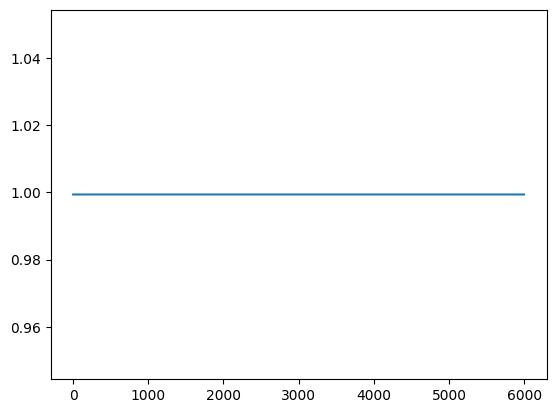

In [65]:
mon.
# plt.plot(mon.beta0[1,:])

In [83]:
with open('line_no_spacecharge_and_particle.json') as f:
    dct = json.load(f)

with open('line_no_spacecharge_and_particle.json') as f:
    dct_space = json.load(f)

line = dct["line"]
particle = dct["particle"]

for i in dct_space:
    # print(10*"-")
    # for j in dct[i]:
    #     print(j)
    # print(dct_space["elements"]["sps$start"])
    # print(10*"-")
    print(i)
# dct_space["line"]
# print(dct["elements"]["sps$start"])

line
particle


In [4]:
inputs_tab = json.load(open("heb_ring_withcav.json"))

In [8]:
inputs_tab.keys()

dict_keys(['elements', 'element_names', 'config', '_extra_config', '_var_management_data', '_var_manager', 'metadata'])

In [28]:
import json
import numpy as np

# Sample dictionary with NumPy int64
data_dict = dct


# Function to convert np.int64 to int
def convert_numpy_int(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    elif isinstance(obj, dict):
        return {key: convert_numpy_int(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_int(item) for item in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

# Convert all np.int64 values in the dictionary to regular int
data_dict = convert_numpy_int(data_dict)

# Writing to a JSON file
with open('data.json', 'w') as json_file:
    json.dump(data_dict, json_file, indent=4)

print("Dictionary written to data.json successfully!")


Dictionary written to data.json successfully!


In [44]:
with open("data.json", "r") as json_son_file:
    monitor_dict = json.load(json_son_file)

print(monitor_dict.keys())
# print(list(monitor_dict["data"].keys()))
print(list(monitor_dict["data"]["x"]))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

